In [100]:
from gym.spaces import Box
from gym import ObservationWrapper, Wrapper
import gym
import random
import numpy as np
import tensorflow as tf
import cv2
from keras.layers import Conv2D, Flatten
import matplotlib.pyplot as plt
class PreprocessImage(ObservationWrapper):
    #TENSOR V1 was used for this process
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)
        self.img_size = (84,84)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    #Take observation of image
    def observation(self, img):
        img = img[34:-16, :, :]
        img = cv2.resize(img, self.img_size)
        img = img.mean(-1, keepdims=True)
        img = img.astype('float32') / 255.
        return img
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order ='tensorflow'):
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    #Resets framebuffer
    def reset(self):
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        #Play one step and update framebuffer
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    #Updat frame buffer with next set of frames
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)




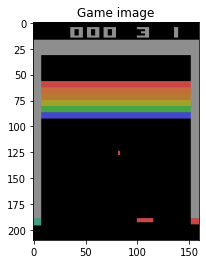

c:\users\mikel\pythonprojects\pythonproject\venv\lib\site-packages\tensorflow\python\client\session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


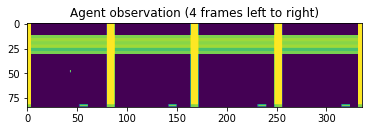

In [101]:
from tensorflow.python.keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.models import Sequential
import ffmpeg
from pyvirtualdisplay import Display

def make_env():
    #Resize image and stack 4 image frames
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessImage(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
#env = gym.wrappers.Monitor(make_env(),directory="videos",force=True)
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));


tf.compat.v1.reset_default_graph()
session = tf.compat.v1.InteractiveSession()
tf.compat.v1.disable_eager_execution()


class DQN:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):

        #Model Structure
        with tf.compat.v1.variable_scope(name, reuse=reuse):
            self.model = Sequential()
            self.model.add(Conv2D(32, 8, (4,4), activation='relu', padding='valid', input_shape=(state_shape)))
            self.model.add(MaxPooling2D())
            self.model.add(Conv2D(64, 4, (2,2), activation='relu', padding='valid'))
            self.model.add(Conv2D(64, 3, (1,1), activation='relu', padding='valid'))
            self.model.add(MaxPooling2D())
            self.model.add(Flatten())
            self.model.add(Dense(256, activation="elu"))
            self.model.add(Dense(n_actions, activation='linear'))
            self.model.add(Dense(n_actions, activation='linear',kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))

            self.state_t = tf.compat.v1.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_tf_qvalues(self.state_t)

        self.weights = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    #Return Tensor style qvalues
    def get_tf_qvalues(self, state_t):
        qvalues = self.model(state_t)

        assert tf.compat.v1.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions

        return qvalues

    #return qvalues for next step
    def get_qvalues(self, state_t):
        session = tf.compat.v1.get_default_session()
        return session.run(self.qvalues_t, {self.state_t: state_t})

    #Return random sample of actions to take
    def sample_actions(self, qvalues):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)


In [102]:
dqn_agent = DQN("dqn_agent", state_dim, n_actions, epsilon=0.5)
target_agent = DQN("target_agent", state_dim, n_actions)
session.run(tf.compat.v1.global_variables_initializer())

In [103]:
#Training sequence to
def train(env, agent, num_games=1, greedy=False, t_max=100):
    rewards = []
    s = env.reset()
    for _ in range(num_games):
        reward = 0
        for _ in range(t_max):
            qvalues = dqn_agent.get_qvalues([s])
            env.render()
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)

            reward+= r
            if done:
                s = env.reset()
                break

        rewards.append(reward)
    return np.mean(rewards)

In [104]:
# Captures any recent actions taken by agent
class Replay(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    #Records recent actions to their respective lists
    def create_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)

        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    #Creates random sample out of batch of size 32
    def random_sample(self, batch_size):
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self.create_sample(idxes)

#Record agents actions for n_steps
def record(dqn_agent, env, replay, n_steps=1):
    s = env.framebuffer

    reward = 0.0
    for t in range(n_steps):
        # Record State, Action, Reward, Next State, Action
        qvalues = dqn_agent.get_qvalues([s])
        action = dqn_agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)

        replay.add(s, action, r, next_s, done)
        reward += r
        if done:
            s = env.reset()
        else:
            s = next_s
    #print('Run %d episodes'%(n_steps))
    #print('Mean:', np.mean(reward))
    return reward

In [105]:
#Target network gets loaded with new weights during training
def load_target_agent(dqn_agent, target_agent):
    assigns = []
    for w_agent, w_target in zip(dqn_agent.weights, target_agent.weights):
        assigns.append(tf.compat.v1.assign(w_target, w_agent, validate_shape=True))
    tf.compat.v1.get_default_session().run(assigns)

#Create standard placeholders for (SARSA) elements
obs_ph = tf.compat.v1.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.compat.v1.placeholder(tf.int32, shape=[None])
rewards_ph = tf.compat.v1.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.compat.v1.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.compat.v1.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

#Calculate current and action Q-values
current_qvalues = dqn_agent.get_tf_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

In [106]:
# compute q-values for NEXT states with target network
next_qvalues_target =  target_agent.get_tf_qvalues(next_obs_ph)

next_state_values_target = tf.compat.v1.reduce_max(next_qvalues_target, axis=-1)

reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done

#Computing Loss using Adam optimizer
td_loss = tf.compat.v1.reduce_mean(tf.compat.v1.losses.huber_loss(labels=reference_qvalues, predictions=current_action_qvalues))

optimizer=tf.compat.v1.train.AdamOptimizer(1e-5)
train_step = optimizer.minimize(td_loss, var_list=dqn_agent.weights)

session.run(tf.compat.v1.global_variables_initializer())

In [107]:
#Instantiating replay size of 70000
exp_replay = Replay(70000)
record(dqn_agent, env, exp_replay, n_steps=10000)

# take a sample batch of observations from the buffer
def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.random_sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch,
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

In [108]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

buffer size = 70000, epsilon = 0.98019


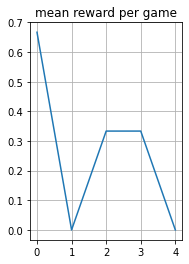

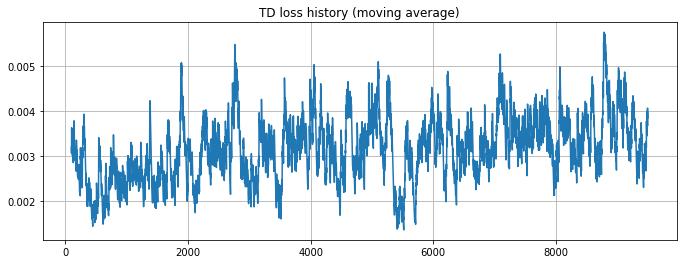

100%|██████████| 10000/10000 [33:44<00:00,  4.94it/s]


In [109]:


#Train for n amount of epochs
dqn_agent.epsilon=1
for i in trange(10000):

    #Record training data
    record(dqn_agent, env, exp_replay, 10)

    # train the network
    _, loss_t = session.run([train_step, td_loss], sample_batch(exp_replay, batch_size=32))
    td_loss_history.append(loss_t)

    # Adjust parameters during training stage
    if i % 500 == 0:
        load_target_agent(dqn_agent, target_agent)
        # reduce epsilon in every iteration until it reaches 1%
        dqn_agent.epsilon = max(dqn_agent.epsilon * 0.999, 0.01)
    #vdisplay.stop()


    if i % 2000 == 0:
        dqn_agent.model.save_weights('\dqn_model_atari_weights.h5')
        mean_rw_history.append(train(make_env(), dqn_agent, num_games=3))

    if i % 500 == 0:
        # plot mean reward per game and TD loss history
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), dqn_agent.epsilon))

        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[25, ])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

In [110]:
#Using python-display library to showcase play after training
from pyvirtualdisplay import Display
# Use of WSL to view live play
#vdisplay = Display()
#vdisplay.start()
dqn_agent.model.set_weights('\dqn_model_atari_weights.h5')
sessions = [train(env, dqn_agent, num_games=1) for _ in range(1)]
#vdisplay.stop()

ValueError: You called `set_weights(weights)` on layer "sequential" with a weight list of length 27, but the layer was expecting 12 weights. Provided weights: \dqn_model_atari_weights.h5...